In [15]:
import os
import numpy as np
import pandas as pd
from analysis import *

import random

from MulticoreTSNE import MulticoreTSNE as TSNE
import fastcluster

from scipy.cluster.hierarchy import dendrogram
from hdbscan import HDBSCAN

from pyclustering.cluster.kmeans import *
from pyclustering.cluster.kmedians import *
from pyclustering.cluster.elbow import elbow

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np

import seaborn as sns

In [3]:
sdss_df = import_sdss ("%s/Databases/SDSSMOC4/data/sdssmocadr4.tab" % os.getcwd())

# Drop information not relevant to this problem, along with the SMOC_ID, which just indicates
# an SDSS observation; one asteroid can have multiple SMOC_ID, so it isn't a useful identifier.
sdss_df.drop(labels=['OBJ_ID_RUN', 'OBJ_ID_COL', 'OBJ_ID_FIELD',
                     'OBJ_ID_OBJ', 'ROWC', 'COLC', 'JD_ZERO', 'RA',
                     'DEC', 'LAMBDA', 'BETA', 'PHI', 'VMU', 'VMU_ERROR',
                     'VNU', 'VNU_ERROR', 'VLAMBDA', 'VBETA', 'IDFLAG',
                     'RA_COMPUTED', 'DEC_COMPUTED', 'V_MAG_COMPUTED',
                     'R_DIST', 'G_DIST', 'OSC_CAT_ID', 'ARC',
                     'EPOCH_OSC', 'A_OSC', 'E_OSC', 'I_OSC', 'LON_OSC',
                     'AP_OSC', 'M_OSC', 'PROP_CAT_ID', 'A_PROP',
                     'E_PROP', 'SIN_I_PROP', 'V_MAG', 'B_MAG', 'H', 'G',
                     'A_MAG', 'A_ERR', 'SMOC_ID', 'PHASE', 'D_COUNTER', 
                     'TOTAL_D_COUNT'],
                     axis=1, inplace=True)

In [4]:
tax_df = import_tax("%s/Databases/SDSSTaxonomy/data/sdsstax_ast_table.tab" % os.getcwd())
tax_df.drop(labels=['AST_NAME', 'SCORE', 'NCLASS', 'METHOD', 'BAD',
                    'SEQUENCE', 'PROPER_SEMIMAJOR_AXIS',
                    'PROPER_ECCENTRICITY',
                    'SINE_OF_PROPER_INCLINATION',
                    'OSC_SEMIMAJOR_AXIS', 'OSC_ECCENTRICITY',
                    'OSC_INCLINATION'],
                     axis=1, inplace=True)

In [5]:
wave_mags = ["U_MAG", "G_MAG", "R_MAG", "I_MAG", "Z_MAG"]
wave_errs = ["U_ERR", "G_ERR", "R_ERR", "I_ERR", "Z_ERR"]

# Ensure data integrity. Every observation MUST have a U, G, R, I, and Z value, and associated error.
sdss_df.dropna(subset=wave_mags + wave_errs, inplace=True)

In [6]:
merged = merge(sdss_df, tax_df, ["PROV_ID", "AST_NUMBER"])
merged.reset_index(drop=True, inplace=True)

In [7]:
training_data = merged[wave_mags].values[:100000]

In [8]:
merged_projection = TSNE(n_jobs=8).fit_transform(training_data)

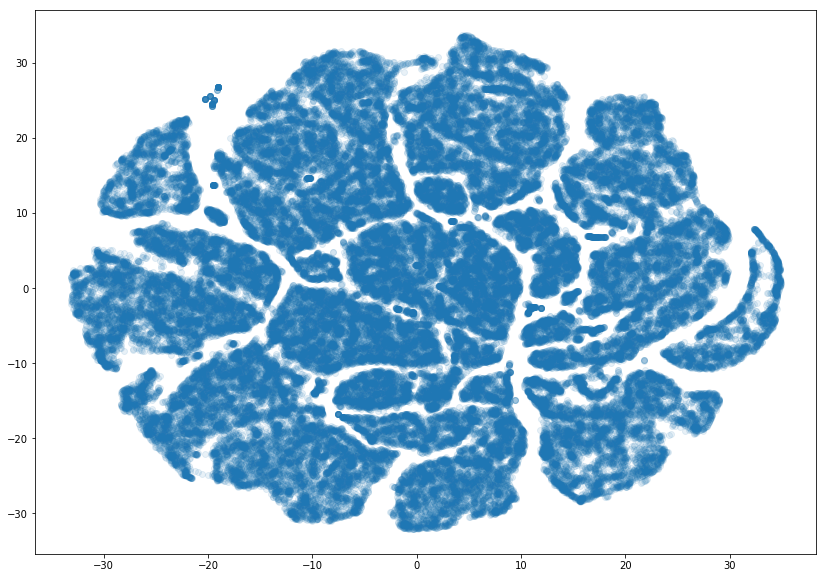

In [9]:
# Actually plot our data
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, alpha=0.1)

In [10]:
# Plot what Carvano got.
unique_tax = merged["CLASSIFICATION"].unique()
tax_color_dict = dict(zip(unique_tax, list(range(len(unique_tax)))))

color_palette = sns.color_palette('Paired', len(unique_tax))

cluster_colors = [color_palette[tax_color_dict[x]] if tax_color_dict[x] >= 0
                  else (0.5, 0.5, 0.5)
                  for x in merged["CLASSIFICATION"]]

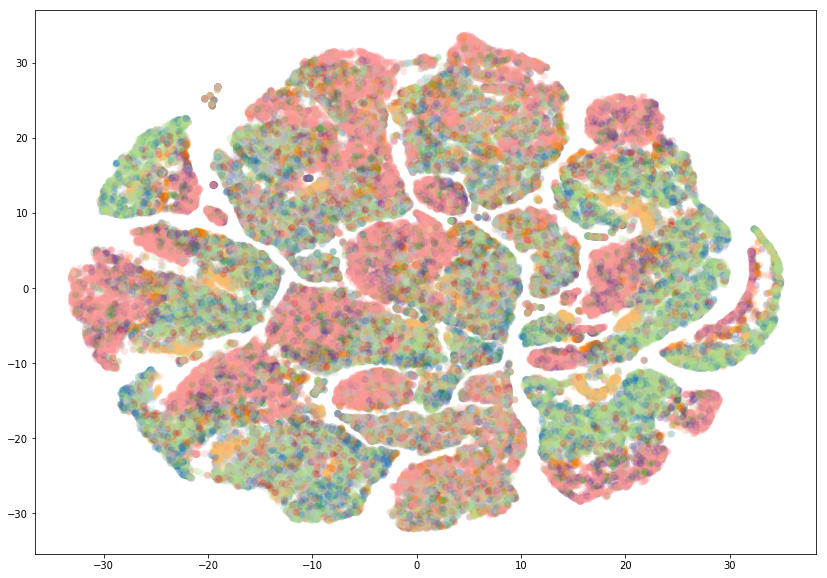

In [11]:
# Actually plot our data
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

## Elbow Method
Manual computation of clusters, in the form of the equation

$$
Elbow_{k} = \frac{\left ( y_{0} - y_{1} \right )x_{k} + \left ( x_{1} - x_{0} \right )y_{k} + \left ( x_{0}y_{1} - x_{1}y_{0} \right )}{\sqrt{\left ( x_{1} - x_{0} \right )^{2} + \left ( y_{1} - y_{0} \right )^{2}}}
$$

given a kmin-point ($x_0$, $y_0$) the kmax-point ($x_1$, $y_1$), the value $x_k$, the amount of clusters, and $y_k$, the within-cluster error.

In [ ]:
kmin, kmax = 1, 20
elbow_instance = elbow(training_data, kmin, kmax)

In [ ]:
# process input data and obtain results of analysis
elbow_instance.process()
amount_clusters = elbow_instance.get_amount()

In [ ]:
amount_clusters

In [ ]:
# perform cluster analysis using K-Means algorithm
centers = kmeans_plusplus_initializer(training_data, amount_clusters).initialize()
kmeans_instance = kmeans(training_data, centers)
kmeans_instance.process()

In [ ]:
# obtain clustering results and visualize them
elbow_clusters = kmeans_instance.get_clusters()
elbow_centers = kmeans_instance.get_centers()

In [ ]:
# Now, compare against Carvano.
apply_classification(merged, elbow_clusters, "ELBOW_CLASSIFICATION")

In [ ]:
color_palette = sns.color_palette('Paired', len(elbow_clusters))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x, arr in enumerate(elbow_clusters)]

In [ ]:
# Actually plot our data
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

## K-Means++
Now, we do a graphical analysis to determine the number of clusters.

In [ ]:
# Use k-means++ to guess centers
run_bound = 25
run_max = 10

all_args = [(training_data, i) for i in range(1, run_bound)]

with Pool(8) as p:
    all_output = [p.starmap(k_means_pp, all_args) for i in range(run_max)]

In [ ]:
fig = plt.figure(figsize=(14,10))
for i in range(run_max):
    # Get the full resample i's array of errors.
    err = [all_output[i][j][1] for j in range(run_bound - 1)]
    plt.plot(range(len(err) + 1), [None,] + err)
    
ax = fig.gca()
ax.set_xticks(numpy.arange(0, 25, 1))
plt.title("K-Means++ Cost vs. Clusters")
plt.ylabel("Sum of Squared Error")
plt.xlabel("Number of Clusters")
plt.grid()
plt.show()

In [ ]:
graphical_clusters = 8

In [ ]:
# perform cluster analysis using K-Means algorithm
centers = kmeans_plusplus_initializer(training_data, graphical_clusters).initialize()
kmeans_instance = kmeans(training_data, centers)
kmeans_instance.process()

In [ ]:
# obtain clustering results and visualize them
kmeans_clusters = kmeans_instance.get_clusters()
kmeans_centers = kmeans_instance.get_centers()

In [ ]:
# Now, compare against Carvano.
apply_classification(merged, kmeans_clusters, "KMEANS_CLASSIFICATION")

In [ ]:
color_palette = sns.color_palette('Paired', len(kmeans_clusters))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x, arr in enumerate(kmeans_clusters)]

In [ ]:
# Actually plot our data
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

## HDBSCAN

In [ ]:
# Create HDBSCAN algorithm instance for cluster analysis
# chebyshev
# cityblock
# infinity
# l1
hdbscan_instance = HDBSCAN().fit(training_data)

In [ ]:
hdbscan_instance.labels_.max()

In [ ]:
hdbscan_clusters = [np.where(hdbscan_instance.labels_ == i)[0] for i in range(-1, hdbscan_instance.labels_.max())]

In [ ]:
# Now, compare against Carvano.
apply_classification(merged, hdbscan_clusters, "HDBSCAN_CLASSIFICATION")

In [ ]:
color_palette = sns.color_palette('Paired', len(hdbscan_clusters))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x, arr in enumerate(hdbscan_clusters)]

In [ ]:
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

## Agglomerative

In [65]:
links = fastcluster.linkage(training_data, method='weighted', metric='cityblock')

MemoryError: 

In [47]:
fig = plt.figure(figsize=(45, 20))
dn = dendrogram(links)
plt.show()

KeyboardInterrupt: 

In [54]:
from scipy.cluster.hierarchy import fcluster
#clusters = fcluster(links, 8, criterion='distance')
clusters = fcluster(links, 16, criterion='maxclust')
np.max(clusters)

16

In [55]:
agglomerative_clusters = [np.where(clusters == i)[0] for i in range(np.max(clusters))]

In [56]:
# Now, compare against Carvano.
apply_classification(merged, agglomerative_clusters, "AGGLOMERATIVE_CLASSIFICATION")

In [57]:
color_palette = sns.color_palette('Paired', len(agglomerative_clusters))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x, arr in enumerate(agglomerative_clusters)]

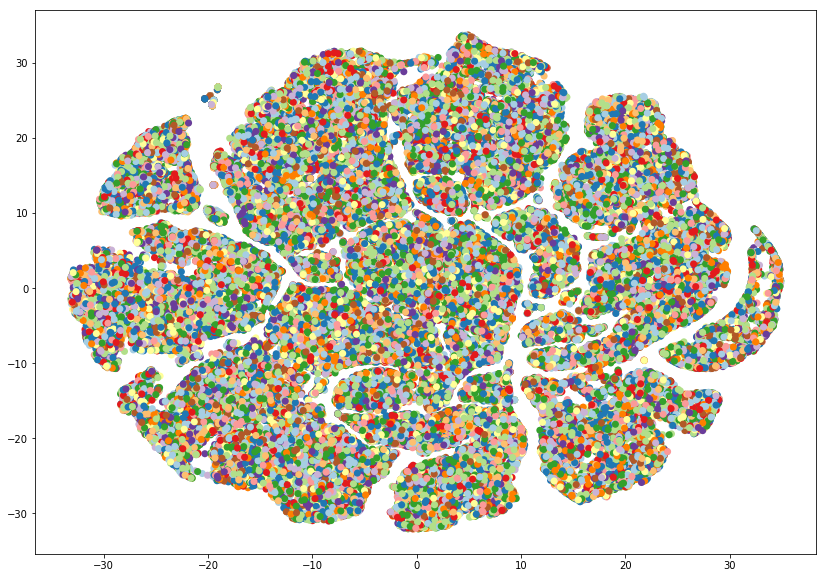

In [59]:
plt.figure(figsize=(14, 10))
plt.scatter(*merged_projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

In [64]:
type(training_data[0])

numpy.ndarray